In [ ]:
from rocketpy import Rocket, Environment, Flight, LiquidMotor, Fluid, CylindricalTank, MassFlowRateBasedTank, MassBasedTank
from math import exp
from datetime import datetime, timedelta
from CoolProp.CoolProp import PropsSI
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import excel_sheet_functions as ex

In [ ]:
#open rocket from Oskar
env = Environment( 
    latitude=28.61,
    longitude=-80.6, # from OR
)
env.set_atmospheric_model(
    type="custom_atmosphere",
    pressure=None,
    temperature=300,
    wind_u=[
        (0, -4.47), 
        (1000, -4.47), 
        (5000, -4.47),
    ],
    wind_v=[
        (0, 0), 
        (1000, 0), 
        (5000, 0), 
    ],
)
env.set_elevation(0) # from OR
env.max_expected_height = 10000
# env.plots.atmospheric_model()

# env.info()

In [ ]:
# Stałe dla turbulencji
external_tank_diameter = 0.2
tank_height = 1.13
thickness_tank = 0.005
thickness_piston = 0.01

# Parametry, które potrzebuję
p_0 = 63e5 #ciśnienie początkowe
piston_position = 0.85
total_oxidizer_mass = 18
flux_time = 11.2 # the start time will be useful as well
# csv z masą utleniacza i paliwa w czasie
ethanol_temperature = 300
# Parametry, które zakładem
gas_initial_mass_fuel = 0

# Parametry, które wyliczam
N20_liq_density = PropsSI("D", "P", p_0, "Q", 0, "NitrousOxide")
N20_gas_density = PropsSI("D", "P", p_0, "Q", 1, "NitrousOxide")
ethanol_liq_density = PropsSI("D", "P", p_0-1e5, "T", ethanol_temperature, "Ethanol") # PropSI pokazuje 63e5 powyżej krytycznego, dlatego odejmuję
ethanol_gas_density = PropsSI("D", "P", p_0-1e5, "Q", 1, "Ethanol")

volume_tank = 0.25*np.pi*(external_tank_diameter-2*thickness_tank)**2*tank_height
volume_piston = 0.25*np.pi*(external_tank_diameter-2*thickness_tank)**2*thickness_piston
volume_oxidizer = piston_position*volume_tank
volume_fuel = volume_tank - volume_oxidizer - volume_piston

gas_initial_mass_ox = (volume_oxidizer - (total_oxidizer_mass / N20_liq_density)) / (1/N20_gas_density - 1/N20_liq_density)
liquid_initial_mass_ox = total_oxidizer_mass - gas_initial_mass_ox
liquid_initial_mass_fuel = volume_fuel * ethanol_liq_density

# Parametry stricte pod tank_geometry
tank_radius = (external_tank_diameter - 2*thickness_tank) / 2
adjusted_height_ox = piston_position*tank_height
adjusted_height_fuel = tank_height - adjusted_height_ox - thickness_piston

# Dla sprawdzenia czy wychodzi mi to samo co volume_oxidizer i volume_fuel
fuel_tank_volume = np.pi * tank_radius**2 * adjusted_height_fuel
oxidizer_tank_volume = np.pi * tank_radius**2 * adjusted_height_ox

In [ ]:
oxidizer_liq = Fluid(name="N2O_l", density=N20_liq_density)
oxidizer_gas = Fluid(name="N2O_g", density=N20_gas_density)
fuel_liq = Fluid(name="ethanol_l", density=ethanol_liq_density) 
fuel_gas = Fluid(name="ethanol_g", density=ethanol_gas_density)

In [ ]:
# Tank geometry
oxidizer_tank_geometry = CylindricalTank(
    radius=tank_radius,
    height=adjusted_height_ox,
)
fuel_tank_geometry = CylindricalTank(
    radius=tank_radius,
    height=adjusted_height_fuel,
)

In [ ]:
# Define tanks
mass_flow_rate_liq = round(liquid_initial_mass_ox/flux_time, 2) - 0.005 # waiting for csv
mass_flow_rate_gas = round(gas_initial_mass_ox/flux_time - 0.005, 2) # waiting for csv

oxidizer_tank = MassFlowRateBasedTank(
    name="oxidizer tank",
    geometry=oxidizer_tank_geometry,
    flux_time=(1, flux_time+1), 
    initial_liquid_mass=liquid_initial_mass_ox, 
    initial_gas_mass=gas_initial_mass_ox,
    liquid_mass_flow_rate_in=0,
    liquid_mass_flow_rate_out=mass_flow_rate_liq, 
    gas_mass_flow_rate_in=0,
    gas_mass_flow_rate_out=mass_flow_rate_gas, 
    liquid=oxidizer_liq,
    gas=oxidizer_gas,
)

In [ ]:
#Fuel tank
fuel_mass_flow_rate = liquid_initial_mass_fuel / flux_time - 0.01
fuel_tank = MassFlowRateBasedTank(
    name="fuel tank",
    geometry=fuel_tank_geometry,
    flux_time=(1, flux_time+1),
    initial_liquid_mass=liquid_initial_mass_fuel-0.00001, #Same as above, only guess
    initial_gas_mass=gas_initial_mass_fuel,
    liquid_mass_flow_rate_in=0,
    liquid_mass_flow_rate_out=fuel_mass_flow_rate, #heuristics
    gas_mass_flow_rate_in=0,
    gas_mass_flow_rate_out=0,
    liquid=fuel_liq,
    gas=fuel_gas,
)

In [ ]:
z4000 = LiquidMotor(
    thrust_source=".\\data\\AGH-SS_Z4000-10sBurn-optimal.eng", #From tests
    dry_mass=2.7,
    dry_inertia=(0.02143, 0.02143, 0.005535), #This should be calculated using CAD, here I use estimations
    nozzle_radius=0.036, #From technical report
    center_of_dry_mass_position=0.144, #Estimated from openrocket
    nozzle_position=0,
    burn_time=14.4,
    coordinate_system_orientation="nozzle_to_combustion_chamber",
)
z4000.add_tank(tank=oxidizer_tank, position=1.285) #From nozzle to center of the tank
z4000.add_tank(tank=fuel_tank, position=2.01)

In [ ]:
trb = Rocket(
    radius=0.1,
    mass=58.367, 
    inertia=(75.502, 75.502, 0.43), 
    power_off_drag=".\\data\\powerondrag.csv",  
    power_on_drag='.\\data\\powerondrag.csv',
    center_of_mass_without_motor=2.75, 
    coordinate_system_orientation="nose_to_tail", 
)
trb.add_motor(z4000, position=4.49)

In [ ]:
#Aerodynamic surfaces taken from openrocket
nose_cone = trb.add_nose(
    length=0.7, kind="lvhaack", position=0
)

fin_set = trb.add_trapezoidal_fins(
    n=4,
    root_chord=0.287,
    tip_chord=0.059,
    span=0.202,
    sweep_length=0.228,
    position=4.21,
    cant_angle=0,
)

tail = trb.add_tail(
    top_radius=0.1, bottom_radius=0.065, length=0.287, position=4.21
)

rail_buttons = trb.set_rail_buttons(
    upper_button_position=2.17, #Just some value, not accurate
    lower_button_position=3.5, #Just some value, not accurate
    angular_position=0, #Just some value, not accurate #0 stopni
)

main = trb.add_parachute(
    name="main",
    cd_s=12.72, # cd * parachute area
    trigger=1000,      
    sampling_rate=105,
    lag=6,
    noise=(0, 8.3, 0.5),
    radius=2.25, 
    height=2.25,
    porosity=0.0432,
)

drogue = trb.add_parachute(
    name="drogue",
    cd_s=1.218,
    trigger="apogee", 
    sampling_rate=105,
    lag=1,
    noise=(0, 8.3, 0.5),
    radius=0.76,
    height=0.76,
    porosity=0.0432,
)

# trb.draw()
# trb.plots.drag_curves()

In [ ]:
test_flight = Flight(
    rocket=trb, environment=env, rail_length=15.24, inclination=87, heading=90
    )

In [ ]:
test_flight.prints.out_of_rail_conditions()
test_flight.plots.trajectory_3d()

In [ ]:
print(ex.rail_departure_velocity_in_ft_per_sec(test_flight))

In [ ]:
print(ex.average_thrust_during_rail_phase(test_flight, z4000, trb))

In [ ]:
print(ex.max_static_margin(test_flight))
print(ex.min_static_margin(test_flight))

In [ ]:
print(test_flight.max_acceleration)
print(ex.max_acceleration(test_flight))
print(ex.max_acceleration_in_g(test_flight))

In [ ]:
print(ex.max_acceleration_power_on_in_g(test_flight))

In [ ]:
print(ex.max_velocity_in_ft_per_sec(test_flight))

In [ ]:
print(ex.max_mach(test_flight))

In [ ]:
print(ex.max_q_in_psf_and_altitude_in_ft(test_flight))

In [ ]:
print(test_flight.apogee)
print(test_flight.apogee_time)
print(test_flight.apogee*3.28084)

In [ ]:
print(ex.max_pitch_moment(test_flight))
print(ex.max_yaw_moment(test_flight))

In [ ]:
print(ex.distance_from_pad(test_flight))

In [ ]:
mach_df = ex.get_df_for_mach_number(test_flight)
aoa_df = ex.get_df_for_angle_of_attack(test_flight)
cog_df = ex.get_df_for_center_of_gravity(trb, test_flight)
cop_df = ex.get_df_for_center_of_pressure(trb, test_flight)
merged_cp_and_mach_df = ex.get_merged_df_for_cp_and_mach_number(trb, test_flight)
mach_df.head()
cog_df.tail()

In [ ]:
x_mach = np.array(cop_df["x"])
y_cop = np.array(cop_df["Scalar"])
font = {'family': 'serif',
        'color':  'black',
        'size': 12}
plt.plot(x_mach, y_cop)
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
plt.xlabel("Mach number", fontdict=font)
plt.ylabel("Center of pressure position (m)", fontdict=font)
plt.title("Center of pressure position vs Mach number", fontdict=font)
plt.show()

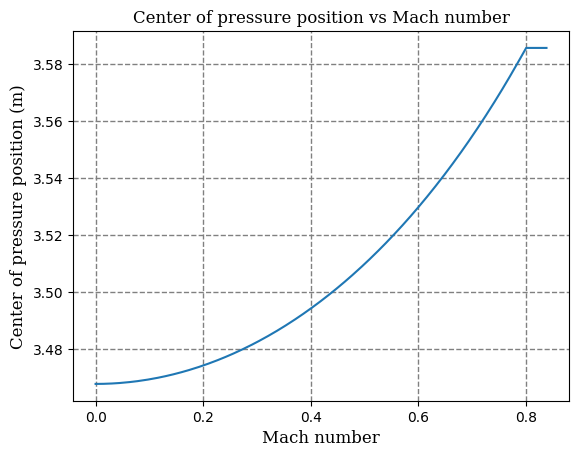

In [55]:
ex.plot_center_of_pressure_vs_mach_number(cop_df)

In [ ]:

y2_cog = np.array(cog_df["Center of Mass Position (m)"])
merged_cp_and_mach_df_reshaped = merged_cp_and_mach_df.groupby(merged_cp_and_mach_df.index // 10).mean()
x_time = np.array(merged_cp_and_mach_df_reshaped["Time"])
y_cop = np.array(merged_cp_and_mach_df_reshaped["Scalar"])
plt.plot(x_time, y_cop)
plt.plot(x_time, y2_cog)
plt.xlabel("Time (s)", fontdict=font)
plt.ylabel("Position (m)", fontdict=font)
plt.title("Center of pressure and center of gravity position vs time", fontdict=font)
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)


In [ ]:
reshaped_aoa_df = aoa_df.iloc[:250, :]
merged_cp_and_mach_df_reshaped_to_250 = merged_cp_and_mach_df.groupby(merged_cp_and_mach_df.index // 4).mean()
merged_cp_and_mach_df_reshaped_to_250.head()
merged_cop_and_aoa_df = pd.merge_asof(
    reshaped_aoa_df, 
    merged_cp_and_mach_df_reshaped_to_250, 
    left_on='Time (s)', 
    right_on='Time', 
    direction='nearest'
)
x_aoa = np.array(merged_cop_and_aoa_df["Angle of Attack (°)"])
y_cop = np.array(merged_cop_and_aoa_df["Scalar"])
plt.plot(x_aoa, y_cop)
plt.xlabel("Angle of attack (deg)", fontdict=font)
plt.ylabel("Center of pressure position (m)", fontdict=font)
plt.title("Center of pressure position vs angle of attack", fontdict=font)
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)

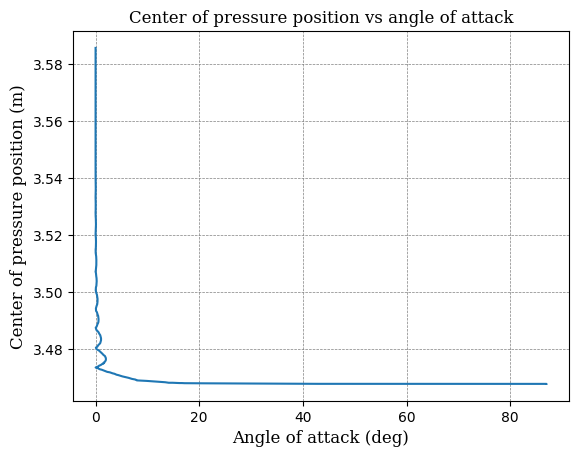

In [54]:
ex.plot_center_of_pressure_vs_angle_of_attack(merged_cp_and_mach_df, aoa_df)

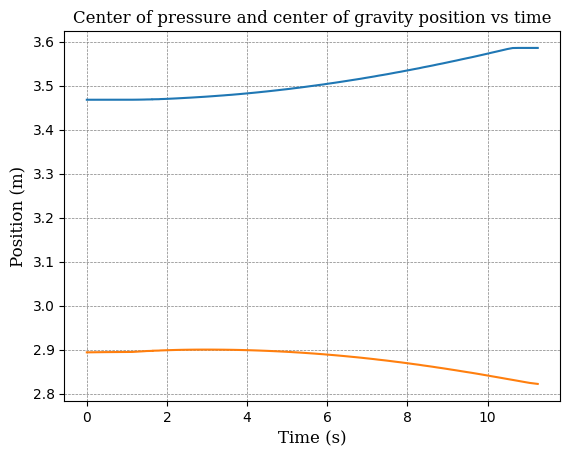

In [51]:
ex.plot_center_of_gravity_and_of_pressure_vs_time(cog_df, merged_cp_and_mach_df)


In [ ]:

import numpy as np
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

# get aoa
raw_alpha = np.array(test_flight.angle_of_attack)
alpha_values = raw_alpha[:, 1] 
time_values = raw_alpha[:, 0]


# from leaving rail to apogee
t_exit = test_flight.out_of_rail_time
t_apogee = test_flight.apogee_time
mask = (time_values > t_exit + 0.1) & (time_values < t_apogee - 0.1) # Buffer to avoid noise

t_data = time_values[mask]
alpha_data = alpha_values[mask]

# finding peaks
peaks, _ = find_peaks(alpha_data, distance=5) 
peak_times = t_data[peaks]
peak_values = alpha_data[peaks]

# Calculate Damping Ratio (Zeta) using Logarithmic Decrement
damping_ratios = []
damping_times = []

for i in range(len(peak_values) - 1):
    A1 = peak_values[i]
    A2 = peak_values[i+1]
    
    # Only calculate if amplitude is decaying and significant
    if A1 > A2 and A1 > 0.5: 
        delta = np.log(A1 / A2)
        zeta = 1 / np.sqrt(1 + (2 * np.pi / delta)**2)
        damping_ratios.append(zeta)
        damping_times.append(peak_times[i])

# 5. Output Results for Table
if len(damping_ratios) == 0:
    print("sth is not working")
else:
    min_zeta = np.min(damping_ratios)
    max_zeta = np.max(damping_ratios)
    t_min = damping_times[np.argmin(damping_ratios)]
    t_max = damping_times[np.argmax(damping_ratios)]

    print(f"Lowest Damping Ratio:  {min_zeta:.4f} at t={t_min:.2f} s")
    print(f"Highest Damping Ratio: {max_zeta:.4f} at t={t_max:.2f} s")
    
    # Validation
    if min_zeta < 0.05:
        print(f"Underdamped (< 0.05)")
    else:
        print(f"Minimum damping > 0.05. Passed")

    # 6. Plot for Verification
    plt.figure(figsize=(10, 5))
    plt.plot(t_data, alpha_data, label='Angle of Attack (deg)')
    plt.plot(peak_times, peak_values, "x", color='red', label='Peaks')
    plt.xlabel("Time (s)")
    plt.ylabel("Alpha (deg)")
    plt.title("Angle of Attack Oscillations")
    plt.legend()
    plt.grid(True)
    plt.show()

x = np.array(damping_times)
y = np.array(damping_ratios)
plt.plot(x, y, marker='o')
plt.xlabel("Time (s)")
plt.ylabel("Damping Ratio (Zeta)")
plt.title("Damping Ratio over Time")
plt.grid(True)
plt.show()    

In [ ]:
ex.damping_ratio(test_flight)

Mean Damping Ratio: 0.2202


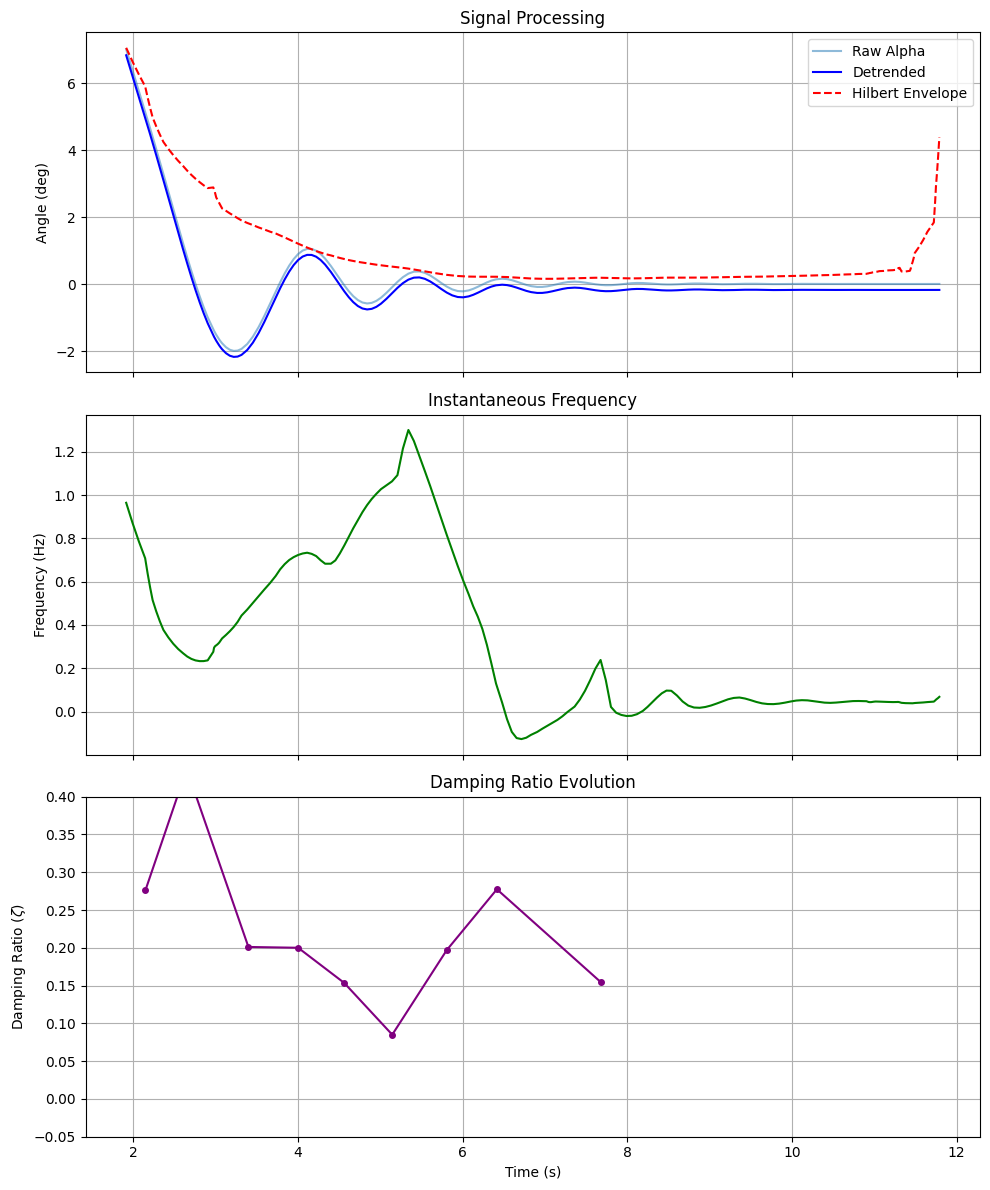

array([0.27632465, 0.43660848, 0.20114997, 0.20008907, 0.15360393,
       0.08504851, 0.19702172, 0.27749301, 0.15483384])

In [56]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert, detrend, savgol_filter

# get aoa
raw_alpha = np.array(test_flight.partial_angle_of_attack)
alpha_values = raw_alpha[:, 1] 
time_values = raw_alpha[:, 0]
# --- 1. SETUP & PREPROCESSING ---
# Assuming you have these from your previous code:
# time_values = ...
# alpha_values = ...

# Filter to flight region (Rail to Apogee)
t_exit = test_flight.out_of_rail_time
t_apogee = test_flight.apogee_time
# OLD CODE:
# mask = (time_values > t_exit + 0.1) & (time_values < t_apogee - 0.1)

# NEW CODE: Focus ONLY on the oscillation event
# We assume the oscillation dies out within 5 seconds of leaving the rail
t_end_analysis = t_exit + 10.0 

mask = (time_values > t_exit + 0.1) & (time_values < t_end_analysis)

# Apply mask
t_data = time_values[mask]
alpha_data = alpha_values[mask]

# NOW run detrend and hilbert on this shorter, cleaner dataset
alpha_detrended = detrend(alpha_data, type='constant') # 'constant' subtracts mean, usually safer for short windows

# --- 2. HILBERT TRANSFORM ---
# Compute the analytic signal
analytic_signal = hilbert(alpha_detrended)

# 1. Extract Amplitude Envelope (Instantaneous Amplitude)
amplitude_envelope = np.abs(analytic_signal)

# 2. Extract Instantaneous Frequency
# Unwrap phase to avoid jumps from pi to -pi
instantaneous_phase = np.unwrap(np.angle(analytic_signal))
# Calculate derivative of phase w.r.t time to get frequency (rad/s)
dt = np.mean(np.diff(t_data))
instantaneous_omega = np.gradient(instantaneous_phase, dt)

# Optional: Smooth the envelope and frequency to reduce noise
# (Window length must be odd, polyorder 2 or 3 is usually good)
window_len = min(51, len(t_data) // 5) 
if window_len % 2 == 0: window_len += 1
amplitude_envelope = savgol_filter(amplitude_envelope, window_len, 3)
instantaneous_omega = savgol_filter(instantaneous_omega, window_len, 3)


# --- 3. SLIDING WINDOW DAMPING CALCULATION ---
damping_ratios = []
damping_times = []

# Define a window size (e.g., 0.5 seconds or a set number of samples)
# Adjust this based on your flight duration. 
window_time_width = 0.5  # seconds
samples_per_window = int(window_time_width / dt)

step = 10 # Step size for sliding (lower = higher resolution, slower code)

for i in range(0, len(t_data) - samples_per_window, step):
    # Get the slice of data
    t_chunk = t_data[i : i + samples_per_window]
    amp_chunk = amplitude_envelope[i : i + samples_per_window]
    omega_chunk = instantaneous_omega[i : i + samples_per_window]
    
    # Check for valid data (avoid log(0) or very low amplitudes that are just noise)
    if np.min(amp_chunk) < 0.1: # Threshold: Ignore if amplitude is < 0.1 deg
        continue

    # Linear Regression on Log(Amplitude)
    # The equation is: ln(A) = -zeta * omega * t + C
    # So the Slope = -zeta * omega
    
    log_amp = np.log(amp_chunk)
    
    # Polyfit returns [slope, intercept]
    # We fit log_amp against relative time (t_chunk - t_chunk[0]) to avoid large number errors
    slope, intercept = np.polyfit(t_chunk - t_chunk[0], log_amp, 1)
    
    # Calculate Zeta
    # Zeta = -Slope / Average_Frequency_in_Window
    avg_omega = np.mean(omega_chunk)
    
    # Protect against divide by zero
    if avg_omega > 0:
        zeta = -slope / avg_omega
        
        # Filter outliers: Zeta is usually between 0 and 0.5 for stable rockets
        if -0.1 < zeta < 1.0:
            damping_ratios.append(zeta)
            damping_times.append(np.mean(t_chunk)) # Store at center of window

# --- 4. OUTPUT & VISUALIZATION ---
damping_ratios = np.array(damping_ratios)
damping_times = np.array(damping_times)

if len(damping_ratios) > 0:
    print(f"Mean Damping Ratio: {np.mean(damping_ratios):.4f}")
    
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12), sharex=True)
    
    # Plot 1: Raw Data vs Detrended + Envelope
    ax1.plot(t_data, alpha_data, label='Raw Alpha', alpha=0.5)
    ax1.plot(t_data, alpha_detrended, label='Detrended', color='blue')
    ax1.plot(t_data, amplitude_envelope, label='Hilbert Envelope', color='red', linestyle='--')
    ax1.set_ylabel("Angle (deg)")
    ax1.legend(loc='upper right')
    ax1.set_title("Signal Processing")
    ax1.grid(True)
    
    # Plot 2: Instantaneous Frequency
    ax2.plot(t_data, instantaneous_omega / (2*np.pi), color='green')
    ax2.set_ylabel("Frequency (Hz)")
    ax2.set_title("Instantaneous Frequency")
    ax2.grid(True)
    
    # Plot 3: Damping Ratio
    ax3.plot(damping_times, damping_ratios, 'o-', markersize=4, color='purple')
    ax3.set_ylabel("Damping Ratio ($\zeta$)")
    ax3.set_xlabel("Time (s)")
    ax3.set_title("Damping Ratio Evolution")
    ax3.set_ylim(-0.05, 0.4) # Adjust limit to focus on relevant area
    ax3.grid(True)
    
    plt.tight_layout()
    plt.show()

else:
    print("Could not extract valid damping ratios (check thresholds or data quality).")
damping_ratios


In [ ]:
test_flight.e0.plot()
test_flight.e1.plot()
test_flight.e2.plot()
test_flight.e3.plot()

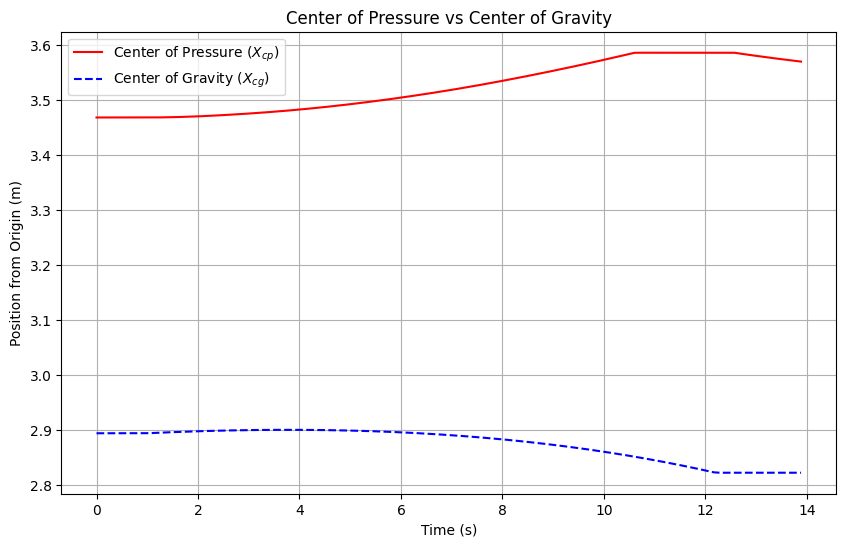

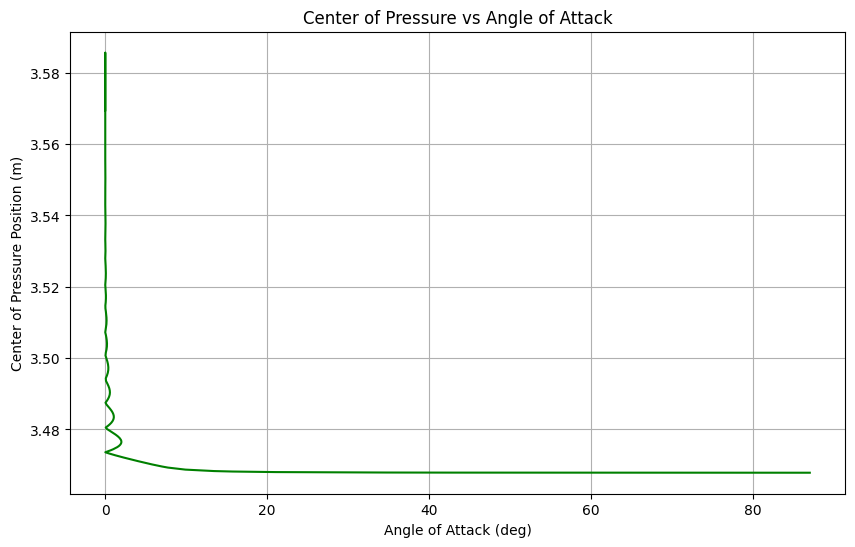

In [53]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Get the Data
# stability_margin is a "Function" object in RocketPy, so we can call it like a function
time = test_flight.time  # Time array
time = time[time <= 14] # Focus on ascent phase
stability = test_flight.stability_margin(time) # Get stability at each time step
aoa = test_flight.angle_of_attack(time) # Get angle of attack at each time step
# 2. Get Physical Constants
# These are stored in the rocket object, not the flight parameters list
diameter = 2 * test_flight.rocket.radius
cg_pos = trb.center_of_mass(time) # CG changes as fuel burns

# 3. Calculate Center of Pressure (Absolute Position)
# Note: This position is relative to the rocket's coordinate origin (usually the nose cone tip or nozzle)
cp_pos = cg_pos + (stability * diameter)

# 4. Plot
plt.figure(figsize=(10, 6))
plt.plot(time, cp_pos, label='Center of Pressure ($X_{cp}$)', color='red')
plt.plot(time, cg_pos, label='Center of Gravity ($X_{cg}$)', color='blue', linestyle='--')
plt.xlabel("Time (s)")
plt.ylabel("Position from Origin (m)")
plt.title("Center of Pressure vs Center of Gravity")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(aoa, cp_pos, label='Angle of Attack (deg)', color='green')
plt.xlabel("Angle of Attack (deg)")
plt.ylabel("Center of Pressure Position (m)")
plt.title("Center of Pressure vs Angle of Attack")
plt.grid(True)
plt.show()